With invariant mapping and injection pattern, when NoC is in congestion, we wanna see if the performance is relevant to injection rate.

In [1]:
import sys
sys.path.append("..")

import os
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import itertools

import global_control as gc
from focus_agent.sampler import LayerSampler, LayerSample
from focus_agent.focus_agent import FocusAgent
from trace_parser.trace_parser import TraceParser
from graph_generator.hyper import HyperGraphGenerator
from trace_parser.visualizer import OpGraphVisualizer
from exp_predictor import ExperiencePredictor
from lp_predictor import LinearProgrammingPredictor

In [2]:
from re import template


random_sample = False
# seed = 1919810
seed = 231411
# seed = 32419031 # x:x:1
# you can customize a sample here, or use a random sample.

delay_tags =  ['delay_w', 'delay_i', 'delay_o']
if random_sample is True:
    sampler = LayerSampler(seed=seed)
    sample = sampler.get_random_sample()

    # minimize delay to 1
    min_delay = min([sample.params['delay_w'], sample.params['delay_i'], sample.params['delay_o']])
    for d in delay_tags:
        sample.params[d] = sample.params[d] // min_delay
else:
    # sample = LayerSample({
    #     'cnt_w': 64,
    #     'cnt_i': 64,
    #     'cnt_o': 64,
    #     'flit_w': 2,
    #     'flit_i': 2,
    #     'flit_o': 2,
    #     'delay_w': 1,
    #     'delay_i': 1,
    #     'delay_o': 1,
    #     'broadcast_w': 1,
    #     'broadcast_i': 0,
    #     'worker': 8,
    # })
    # sample = LayerSample("cw64_ci1856_co64_bw0_bi1_fw9_fi8_fo12_dw58_di2_do58_n14")
    sample = LayerSample("cw64_ci64_co64_bw0_bi1_fw9_fi7_fo12_dw1_di1_do1_n8") # input output overlaps

template_sample = sample
print(template_sample)

cw64_ci64_co64_bw0_bi1_fw9_fi7_fo12_dw1_di1_do1_n8


In [3]:
# run simulation
samples = []

agent = FocusAgent(fake_trace=True, simulate=True)
task_root = os.path.join(gc.dataset_root, "scripts", "throuput")
if not os.path.exists(task_root):
    os.mkdir(task_root)

# let's try exponential delay increment first
# factors = [1, 2, 4, 8, 16, 32, 64, 128, 256, 300, 400, 500, 600, 700, 800, 900, 1024]
# factors = [ 2, 4, 8, 16, 32, 48, 64, 96, 128, 192, 256, 512, 1024]
factors = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
# factors = [64]
# factors = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 32, 48, 64]
for w_factor in tqdm(factors):
    sample_ = copy.deepcopy(template_sample)
    
    # modify wsrc flit size
    sample_.params['flit_w'] = w_factor
    samples.append(sample_)

    sample_.dump(task_root, "model")
    benchmark_path = os.path.join(task_root, "model.yaml")
    try:
        agent.run_focus(benchmark_path, 8, 1024, timeout=300, verbose=False)
    except TimeoutError:
        print(f"Simulation timeout")


100%|██████████| 10/10 [02:00<00:00, 12.05s/it]


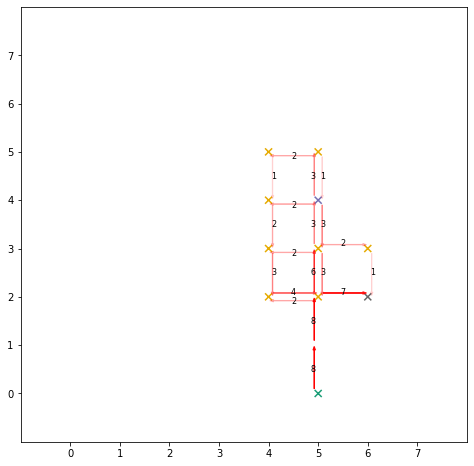

In [4]:
# visualize the first sample
def plot_sample_mapping(sample):

    taskname = str(sample) + f"_b1w1024_8x8"
    # print(taskname)

    # print(agent.get_op_graph_path(taskname))
    # print(agent.get_outlog_path(taskname))
    # print(agent.get_routing_path(taskname))
    # print(agent.get_spec_path(taskname))

    trace_parser = TraceParser(
        agent.get_op_graph_path(taskname),
        agent.get_outlog_path(taskname),
        agent.get_routing_path(taskname),
        agent.get_spec_path(taskname),
    )
    G = trace_parser.graph_parser.get_graph()
    visualizer = OpGraphVisualizer(None, trace_parser)

    visualizer.plot_mapping(str(sample))

for sample in samples:
    plot_sample_mapping(sample)
    break

In [5]:
def check_lp_throughput(sample, verbose=False):
    taskname = str(sample) + f"_b1w1024_8x8"
    print(taskname)

    trace_parser = TraceParser(
        agent.get_op_graph_path(taskname),
        agent.get_outlog_path(taskname),
        agent.get_routing_path(taskname),
        agent.get_spec_path(taskname),
    )
    G = trace_parser.graph_parser.get_graph()

    predictor = LinearProgrammingPredictor(trace_parser, None)
    estimated_latency = predictor.run()
    ground_truth = trace_parser.outlog_parser.get_total_latency()
    print(f"estimated_latency={estimated_latency}, ground_truth={ground_truth}")

for sample in samples:
    check_lp_throughput(sample, False)

cw64_ci64_co64_bw0_bi1_fw2_fi7_fo12_dw1_di1_do1_n8_b1w1024_8x8
estimated_latency=13312.0, ground_truth=7007
cw64_ci64_co64_bw0_bi1_fw4_fi7_fo12_dw1_di1_do1_n8_b1w1024_8x8
estimated_latency=13312.0, ground_truth=7133
cw64_ci64_co64_bw0_bi1_fw8_fi7_fo12_dw1_di1_do1_n8_b1w1024_8x8
estimated_latency=13312.0, ground_truth=11046
cw64_ci64_co64_bw0_bi1_fw16_fi7_fo12_dw1_di1_do1_n8_b1w1024_8x8
estimated_latency=17408.0, ground_truth=20802
cw64_ci64_co64_bw0_bi1_fw32_fi7_fo12_dw1_di1_do1_n8_b1w1024_8x8
estimated_latency=33792.0, ground_truth=37067
cw64_ci64_co64_bw0_bi1_fw64_fi7_fo12_dw1_di1_do1_n8_b1w1024_8x8
estimated_latency=66560.0, ground_truth=69864
cw64_ci64_co64_bw0_bi1_fw128_fi7_fo12_dw1_di1_do1_n8_b1w1024_8x8
estimated_latency=132096.0, ground_truth=135404
cw64_ci64_co64_bw0_bi1_fw256_fi7_fo12_dw1_di1_do1_n8_b1w1024_8x8
estimated_latency=263168.0, ground_truth=266492
cw64_ci64_co64_bw0_bi1_fw512_fi7_fo12_dw1_di1_do1_n8_b1w1024_8x8
estimated_latency=525312.0, ground_truth=528558
cw64_c

In [83]:
# check each flow's throughput
# returns: type -> type
def check_flow_throughput(sample, verbose=False):
    taskname = str(sample) + f"_b1w1024_8x8"
    print(taskname)

    trace_parser = TraceParser(
        agent.get_op_graph_path(taskname),
        agent.get_outlog_path(taskname),
        agent.get_routing_path(taskname),
        agent.get_spec_path(taskname),
    )
    G = trace_parser.graph_parser.get_graph()

    end_intervals = {
        "insrc_worker": 0,
        "wsrc_worker": 0,
        "worker_sink": 0,
    }

    for u, v, eattr in G.edges(data=True):
        p = trace_parser.outlog_parser
        array_size = trace_parser.spec_parser.get_array_size()
        node2pe = lambda x: G.nodes[x]["p_pe"]
        pe2pos = lambda x: (x % array_size, x // array_size)
        uid, vid = node2pe(u), node2pe(v)

        pid2lat = lambda pid: p.get_latency(uid, vid, pid)["end_cycle"]
        end_cycles = np.array([pid2lat(pid) for pid in G.edges[u, v]['pkt']])
        end_interval = np.diff(end_cycles)

        upos, vpos = pe2pos(uid), pe2pos(vid)
        utype, vtype = G.nodes[u]['op_type'], G.nodes[v]['op_type']

        if verbose:
            print(f"{upos}({utype}) -> {vpos}({vtype}): mean {int(end_interval.mean())}, std: {int(end_interval.std())}")
            print(end_interval)
            print()
        end_intervals[f"{utype}_{vtype}"] = max(end_intervals[f"{utype}_{vtype}"], int(end_interval.mean()))
    
    print(f"flit_w = {sample.params['flit_w']}, flit_i = {sample.params['flit_i']}, wsrc_worker = {end_intervals['wsrc_worker']}, insrc_worker = {end_intervals['insrc_worker']}")
    
    predictor = ExperiencePredictor(trace_parser)
    src_to_worker_throughput = predictor.estimate_src_to_worker(str(sample))
    
    # debug: check estimation result
    print(f"estimation: wsrc_worker = {src_to_worker_throughput['wsrc']}")
    print(f"estimation: insrc_worker = {src_to_worker_throughput['insrc']}")

    estimated_latency = int(predictor.predict_latency(str(sample)))
    ground_truth = trace_parser.outlog_parser.get_total_latency()
    print(f"estimated_latency={estimated_latency}, ground_truth={ground_truth}")

    return end_intervals

for sample in samples:
    end_interval = check_flow_throughput(sample, False)
    

cw64_ci64_co64_bw0_bi1_fw2_fi7_fo12_dw1_di1_do1_n1_b1w1024_8x8
flit_w = 2, flit_i = 7, wsrc_worker = 29, insrc_worker = 29
estimation: wsrc_worker = 5.0
estimation: insrc_worker = 16.0
estimated_latency=1664, ground_truth=3223
cw64_ci64_co64_bw0_bi1_fw4_fi7_fo12_dw1_di1_do1_n1_b1w1024_8x8
flit_w = 4, flit_i = 7, wsrc_worker = 29, insrc_worker = 30
estimation: wsrc_worker = 10.0
estimation: insrc_worker = 16.0
estimated_latency=1664, ground_truth=3226
cw64_ci64_co64_bw0_bi1_fw8_fi7_fo12_dw1_di1_do1_n1_b1w1024_8x8
flit_w = 8, flit_i = 7, wsrc_worker = 44, insrc_worker = 44
estimation: wsrc_worker = 20.0
estimation: insrc_worker = 16.0
estimated_latency=1664, ground_truth=3248
cw64_ci64_co64_bw0_bi1_fw16_fi7_fo12_dw1_di1_do1_n1_b1w1024_8x8
flit_w = 16, flit_i = 7, wsrc_worker = 78, insrc_worker = 78
estimation: wsrc_worker = 40.0
estimation: insrc_worker = 16.0
estimated_latency=2560, ground_truth=5079
cw64_ci64_co64_bw0_bi1_fw32_fi7_fo12_dw1_di1_do1_n1_b1w1024_8x8
flit_w = 32, flit_i = 7

In [71]:
for sample in samples:
    flit_w = sample.params['flit_w']
    num_worker = sample.params['worker']
    end_interval = check_flow_throughput(sample, False)
    print(f"flit_w = {sample.params['flit_w']}, flit_i = {sample.params['flit_i']}")
    print(f"w_interval / {num_worker} = {end_interval['wsrc_worker'] / num_worker}")
    print(f"w_interval / {num_worker} - flit_w * 2 = {end_interval['wsrc_worker'] / num_worker - sample.params['flit_w'] * 2}")

    bufs = [2, 3, 3, 4, 4, 5]
    offset = sum([min(flit_w, 2*buf) for buf in bufs]) / len(bufs)
    print(offset)

cw64_ci64_co64_bw0_bi1_fw2_fi7_fo12_dw1_di1_do1_n1_b1w1024_8x8
flit_w = 2, flit_i = 7, wsrc_worker = 9, insrc_worker = 9
estimation: wsrc_worker = 5.0
estimation: insrc_worker = 16.0
estimated_latency=1664, ground_truth=1076
flit_w = 2, flit_i = 7
w_interval / 1 = 9.0
w_interval / 1 - flit_w * 2 = 5.0
2.0
cw64_ci64_co64_bw0_bi1_fw4_fi7_fo12_dw1_di1_do1_n1_b1w1024_8x8
flit_w = 4, flit_i = 7, wsrc_worker = 11, insrc_worker = 11
estimation: wsrc_worker = 10.0
estimation: insrc_worker = 16.0
estimated_latency=1664, ground_truth=1089
flit_w = 4, flit_i = 7
w_interval / 1 = 11.0
w_interval / 1 - flit_w * 2 = 3.0
4.0
cw64_ci64_co64_bw0_bi1_fw8_fi7_fo12_dw1_di1_do1_n1_b1w1024_8x8
flit_w = 8, flit_i = 7, wsrc_worker = 16, insrc_worker = 16
estimation: wsrc_worker = 20.0
estimation: insrc_worker = 16.0
estimated_latency=1664, ground_truth=1324
flit_w = 8, flit_i = 7
w_interval / 1 = 16.0
w_interval / 1 - flit_w * 2 = 0.0
6.666666666666667
cw64_ci64_co64_bw0_bi1_fw16_fi7_fo12_dw1_di1_do1_n1_b1w10

src - worker estimated latency = 5763
ground truth latency = 22429
[  121   150   182   211   240   269   300   329   359   388   417   446
   477   508   538   568   598   627   657   686   716   747   776   805
   834   863   892   921   950   986  1017  1046  1075  1108  1137  1166
  1195  1224  1255  1287  1317  1346  1375  1404  1434  1464  1493  1522
  1552  1582  1612  1644  1674  1703  1732  1763  1792  1821  1850  1882
  1914  1945  1975  2004  2033  2062  2092  2123  2152  2183  2212  2241
  2270  2299  2332  2361  2390  2421  2450  2480  2509  2538  2567  2596
  2626  2657  2686  2715  2744  2774  2809  2839  2868  2897  2928  2958
  2987  3016  3045  3074  3105  3135  3164  3194  3223  3252  3281  3314
  3344  3375  3406  3435  3464  3493  3524  3553  3582  3611  3641  3671
  3700  3729  3761  3790  3820  3850  3879  3910  3941  3975  4004  4035
  4064  4095  4124  4153  4183  4212  4241  4271  4302  4331  4360  4389
  4418  4447  4476  4505  4535  4564  4593  4622  4652  4

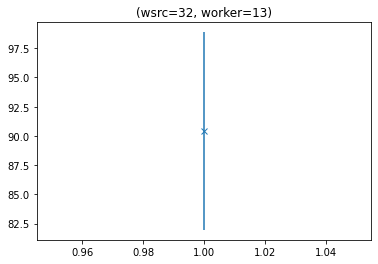

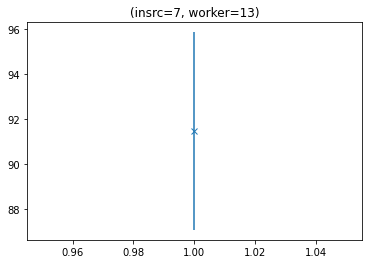

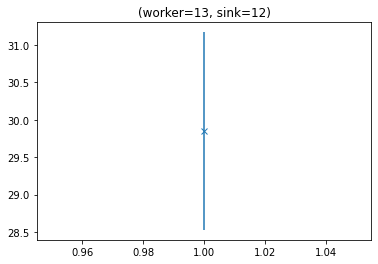

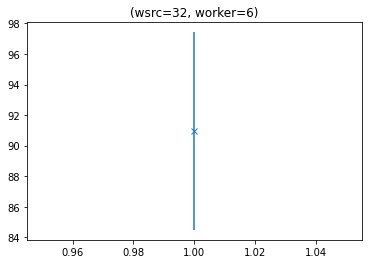

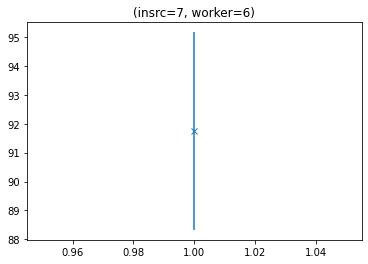

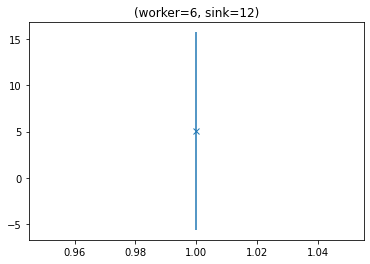

In [38]:
# check packet arrival interval (which approximately is throughput)

end_interval_mean = dict()
end_interval_std = dict()

for factor in factors:
    if factor > 1:
        break

    sample_ = copy.deepcopy(sample)
    for d in delay_tags:
        sample_.params[d] *= factor

    # parse results
    taskname = str(sample_) + f"_b1w1024_8x8"
    trace_parser = TraceParser(
        agent.get_op_graph_path(taskname),
        agent.get_outlog_path(taskname),
        agent.get_routing_path(taskname),
        agent.get_spec_path(taskname),
    )
    G = trace_parser.graph_parser.get_graph()

    # analyze packet arrival time interval
    srcs = [n for n, op_type in G.nodes(data="op_type")
                if op_type == 'wsrc' or op_type == 'insrc']
    workers  = [n for n, op_type in G.nodes(data="op_type")
            if op_type == 'worker']
    sinks = [n for n, op_type in G.nodes(data="op_type") if op_type == "sink"]
    node2pe = lambda x: G.nodes[x]["p_pe"]
    p = trace_parser.outlog_parser

    for w in workers:
        cnt = G.nodes[w]['cnt']
        delay = G.nodes[w]['delay']
        wid = node2pe(w)

        # src to worker edge
        for s in srcs:
            src_type = G.nodes[s]['op_type']
            sid = node2pe(s)
            pid2lat = lambda pid: p.get_latency(sid, wid, pid)["end_cycle"]
            end_cycles = np.array([pid2lat(pid) for pid in G.edges[s, w]['pkt']])
            end_interval = np.diff(end_cycles)

            edge_name = f"({src_type}={sid}, worker={wid})"
            try:
                end_interval_mean[edge_name].append(np.mean(end_interval))
            except:
                end_interval_mean[edge_name] = [np.mean(end_interval)]
            try:
                end_interval_std[edge_name].append(np.std(end_interval))
            except:
                end_interval_std[edge_name] = [np.std(end_interval)]

        # estimate overall latency
        est_lat = (max(end_cycles) - min(end_cycles))
        true_lat = trace_parser.outlog_parser.get_total_latency()
        # print(f"src - worker estimated latency = {est_lat}")
        # print(f"ground truth latency = {true_lat}")

        # break

        # not very useful
        # worker to dst
        for s in sinks:
            sid = node2pe(s)
            pid2lat = lambda pid: p.get_latency(wid, sid, pid)["end_cycle"]
            end_cycles = np.array([pid2lat(pid) for pid in G.edges[w, s]['pkt']])
            end_interval = np.diff(end_cycles)

            print(end_cycles)

            edge_name = f"(worker={wid}, sink={sid})"
            try:
                end_interval_mean[edge_name].append(np.mean(end_interval))
            except:
                end_interval_mean[edge_name] = [np.mean(end_interval)]
            try:
                end_interval_std[edge_name].append(np.std(end_interval))
            except:
                end_interval_std[edge_name] = [np.std(end_interval)]

            est_lat = (max(end_cycles) - min(end_cycles))
            true_lat = trace_parser.outlog_parser.get_total_latency()
            # print(f"worker - dst estimated latency = {est_lat}")
            # print(f"ground truth latency = {true_lat}")


for k in end_interval_mean.keys():
    means = end_interval_mean[k]
    stds = end_interval_std[k]
    l = len(means)

    plt.title(k)
    plt.errorbar(x=factors[:l], y=means, yerr=stds, marker='x')
    plt.show()